The aim of this experiment is just to be able to load the data and display it on a map.

# Dependencies

In [1]:
import subprocess
import pathlib
import csv
import json
import datetime

import cartopy.crs
import cartopy.feature
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.transforms
import numpy as np
import scipy.stats
import scipy.cluster.vq

# Module configuration

In [2]:
# disable the ShapelyDeprecationWarnings
# which are produced by cartopy as I'm using an old version
# as the newest cartopy requires libgeos 3.7.2 but debian bust only has 3.7.1
import warnings
warnings.simplefilter("ignore")

plt.rcParams['figure.figsize'] = [18, 12]  # [12, 8]

# Constants

In [3]:
TUEBINGEN_HBF_ID = '8000141'
repository_path = pathlib.Path(
    subprocess.check_output(['git', 'rev-parse', '--show-toplevel'])
    .rstrip()
    .decode())
assert repository_path.exists()
data_path = repository_path / 'dat'
assert data_path.exists()
stops_path = data_path / 'D_Bahnhof_2020_alle.CSV'
assert stops_path.exists()
trips_020522_path = data_path / 'Mo, 02.05.2022' / TUEBINGEN_HBF_ID
trips_240122_path = data_path / 'Mo, 24.01.2022' / TUEBINGEN_HBF_ID
assert trips_020522_path.exists()
assert trips_240122_path.exists()

# Loading datasets

In [4]:
def load_stops(path: pathlib.Path):
    with path.open() as f:
        reader = csv.reader(f, delimiter=';')
        data = list(reader)
        return (data[0], data[1:])

def load_trip(path: pathlib.Path):
    try:
        with path.open() as f:
            return json.load(f)
    except FileNotFoundError:
        return None
    
def parse_time(time_text: str):
    hours, minutes = time_text.split(':')
    return datetime.timedelta(
        hours=int(hours), minutes=int(minutes))

def load_trips(stops_title, stops):
    trips = []

    for stop in stops:
        stop_id = stop[stops_title['EVA_NR']]
        stop_latitude = float(
            stop[stops_title['Breite']]
            .replace(',', '.'))
        stop_longitude = float(
            stop[stops_title['Laenge']]
            .replace(',', '.'))
        trip_filename = f"{stop_id}.json"
        stop_trips = (
            load_trip(trips_020522_path / trip_filename) or
            load_trip(trips_240122_path / trip_filename))

        if not stop_trips:
            # there are no trips to the stop
            continue

        stop_minimum_travel_time = min(
            parse_time(trip['travel time'])
            for trip in stop_trips)
        trips.append({
            'id': stop_id,
            'latitude': stop_latitude,
            'longitude': stop_longitude,
            'minimum_travel_time': stop_minimum_travel_time})
        
    return trips

In [5]:
stops_title, stops = load_stops(stops_path)
stops_title = {title: i for i, title in enumerate(stops_title)}
trips = load_trips(stops_title, stops)

# Drawing the stops

In [6]:
# credits: https://gist.github.com/graydon/11198540
germany_rectangle = (4.98865807458, 15.4169958839, 47.1024876979, 55.183104153)

In [7]:
longitude_x = [trip['longitude'] for trip in trips]
latitude_y = [trip['latitude'] for trip in trips]
minimum_travel_time_z = [
    trip['minimum_travel_time'].total_seconds() // 60
    for trip in trips]

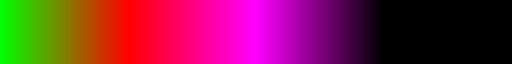

In [8]:
def create_colormap(hex_color_ranges, *, discret=False):
    rgb_color_ranges = [
        (lower_bound, matplotlib.colors.hex2color(hex_color))
        for lower_bound, hex_color in hex_color_ranges]
    lower_bounds, rgb_colors = zip(*rgb_color_ranges)
    red, green, blue = zip(*rgb_colors)
    return matplotlib.colors.LinearSegmentedColormap(
        '',
        segmentdata={
            'red': [(lower_bounds[i],
                     red[max(0, i-1)] if discret else red[i],
                     red[i])
                    for i in range(len(lower_bounds))],
            'green': [(lower_bounds[i],
                       green[max(0, i-1)] if discret else green[i],
                       green[i])
                    for i in range(len(lower_bounds))],
            'blue': [(lower_bounds[i],
                      blue[max(0, i-1)] if discret else blue[i],
                      blue[i])
                    for i in range(len(lower_bounds))]})


def create_colormap_absolute(hex_color_ranges, maximum, **kwargs):
    hex_color_ranges = [
        (lower_bound / maximum, hex_color)
        for lower_bound, hex_color in hex_color_ranges]
    return create_colormap(hex_color_ranges, **kwargs)


create_colormap_absolute(
    [(0, '#00ff00'), (120, '#ff0000'), (240, '#FF00FF'), (360, '#000000'), (480, '#000000')],
    480)

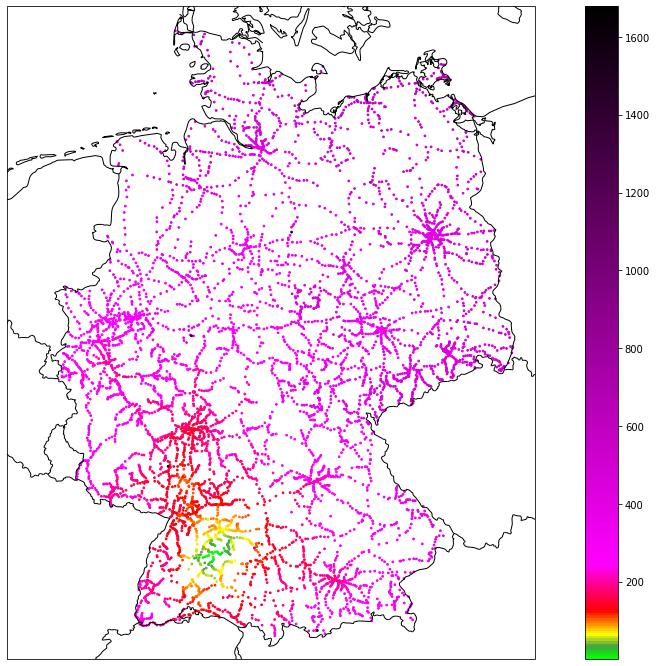

In [9]:
ax = plt.axes(projection=cartopy.crs.Mercator())
ax.set_extent(germany_rectangle)
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.COASTLINE)

# cm = plt.cm.get_cmap('RdYlBu')
# cm = plt.cm.get_cmap('plasma')
minimum_travel_time = min(minimum_travel_time_z)
maximum_travel_time = max(minimum_travel_time_z)
green, dark_green, yellow, red, violet, black = [
    '#00FF00', '#45A045', '#FFFF00', '#FF0000', '#FF00FF', '#000000']
cm = create_colormap_absolute(
    [(0, green), (30, dark_green), (60, yellow), (120, red), (240, violet), (maximum_travel_time, black)],
    maximum_travel_time)
sc = plt.scatter(
    longitude_x, latitude_y, c=minimum_travel_time_z,
    s=3,
    vmin=minimum_travel_time, vmax=maximum_travel_time,
    cmap=cm,
    transform=cartopy.crs.PlateCarree())
plt.colorbar(sc)

plt.show()

By looking at the resulting plot we see that it is not easy to choose a good colormap,  
at least without looking at the distribution of our data.

# Inspecting the data

In [10]:
def vannotate(x, y_ratio, text, align='left', margin=10, **kwargs):
    _, y_upper_bound = plt.ylim()
    x = x + margin if align == 'left' else x - margin
    plt.text(x, y_ratio * y_upper_bound, text,
             horizontalalignment=align, **kwargs)
    
    
def vline(x, y_ratio, text, color='black', text_color=None, **kwargs):
    plt.axvline(x, color=color)
    vannotate(x, y_ratio, text + f' = {x}', color=(text_color or color), **kwargs)

In [11]:
def draw_quantiles():
    vline(np.median(minimum_travel_time_z), 0.95, 'median', color='black', fontsize='x-large')
    vline(np.quantile(minimum_travel_time_z, 0.25), 0.95, '0.25-quantile',
          color='lightgreen', text_color='green', align='right', fontsize='x-large')
    vline(np.quantile(minimum_travel_time_z, 0.75), 0.9, '0.75-quantile',
          color='red', align='left', fontsize='x-large')
    vline(np.quantile(minimum_travel_time_z, 0.95), 0.85, '0.975-quantile',
          color='violet', align='left', fontsize='x-large')

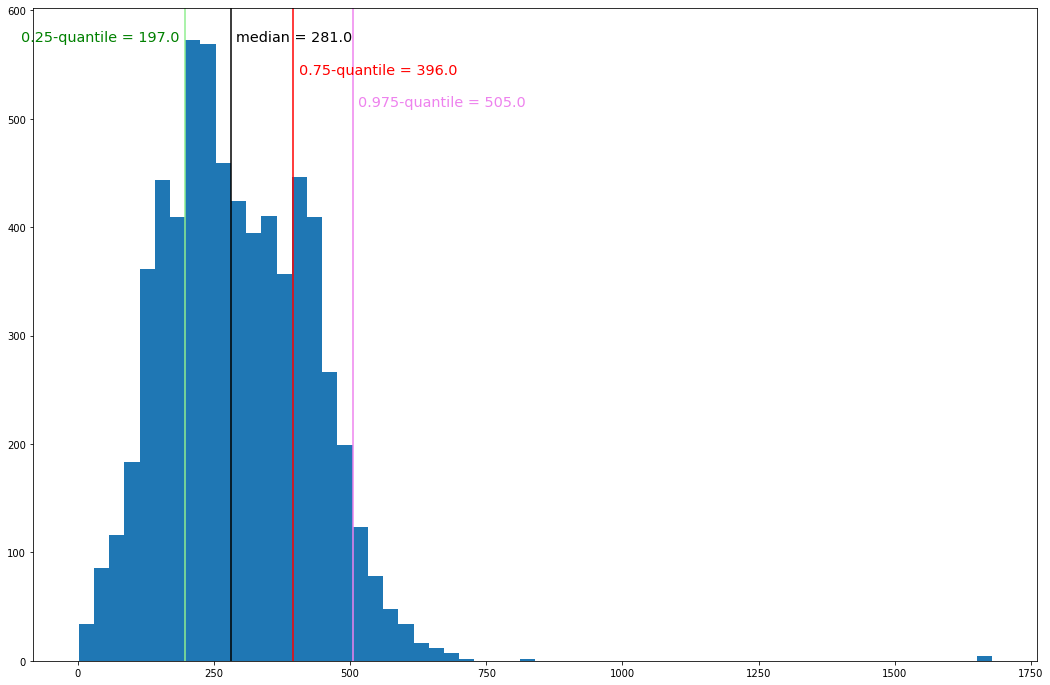

In [12]:
plt.hist(minimum_travel_time_z, bins=60)
draw_quantiles()
plt.show()

So this looks pretty much like a gaussian distribution.  
So let us assume it is gaussian distributed and let us calculate an estimator for it.  

In [13]:
time_mean, time_variance = scipy.stats.norm.fit(minimum_travel_time_z)
time_mean, time_variance

(293.661252900232, 132.87409396958043)

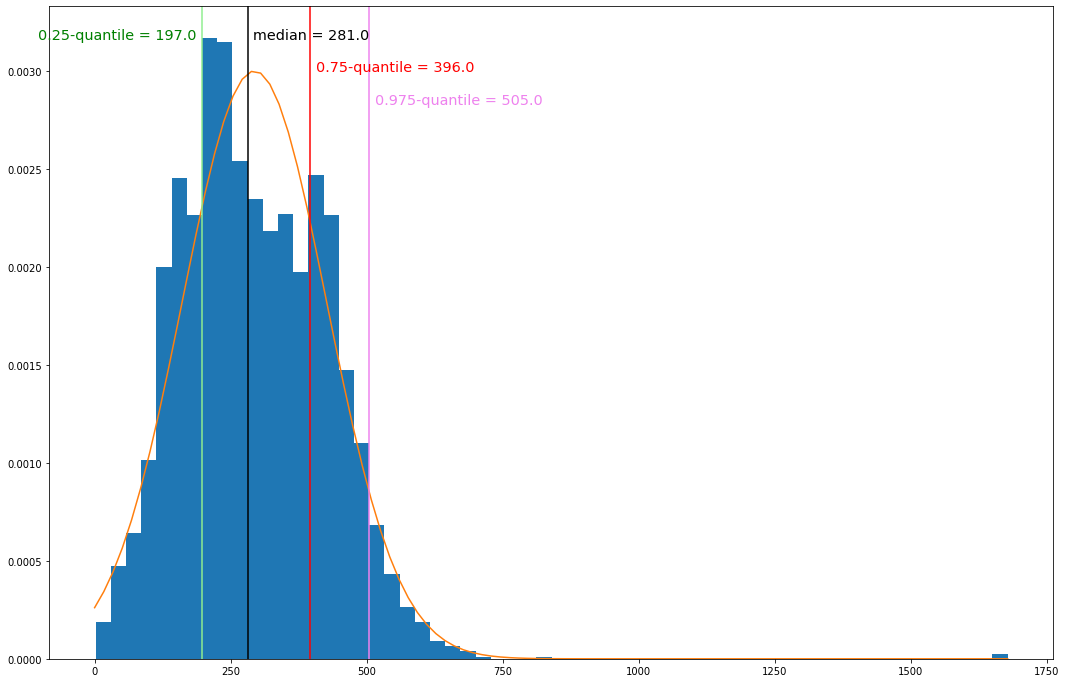

In [14]:
time_X = np.linspace(0, maximum_travel_time, 100)

plt.hist(minimum_travel_time_z, bins=60, density='true')
plt.plot(time_X, scipy.stats.norm.pdf(time_X, loc=time_mean, scale=time_variance))
draw_quantiles()
plt.show()

Now as we have an estimator for the travel time distribution,  
we can use it's cdf to figure out which values we should use as the bounds of our colors.  
In the lecture "Scientific Visualization" we were told that a human can distinguish up to 8 colors well for nominal data.  
Well, in this case we do not work with nominal data but I'm going to use it as guideline.  
So we will choose 8 colors for our colormap.  
As bounds we will use the results of the ppf (percent point function (inverse of cdf)):  
$ppf(cdf(0) + n * (1 - cdf(0))/8)$ for $n \in \{0, ..., 7\}$.  
Further in the lecture "Scientific Visualization" it was suggested to use  

- http://colorbrewer2.org/
- https://color.adobe.com/de/create/color-wheel or
- http://vrl.cs.brown.edu/color  

to choose colors.  

Intuitively I think it makes sense to use a color range from green to red.  
So I'm going to use a diverging color range from green to red which was produced by http://colorbrewer2.org/.  
Further I'm going to choose a qualitative color range from http://colorbrewer2.org/ as a second choice.  

In [15]:
# We use cdf(0) as offset as there are no travel times below zero,
# but our estimator has likelihoods >= 0 for values < 0.
time_cdf_0 = scipy.stats.norm.cdf(0, loc=time_mean, scale=time_variance)
color_bounds = [
    max(0, scipy.stats.norm.ppf(time_cdf_0 + i * (1-time_cdf_0)/8, loc=time_mean, scale=time_variance))
    for i in range(0, 8)]
diverging_colors = tuple(reversed(['#d73027', '#f46d43', '#fdae61', '#fee08b', '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850']))
qualitative_colors = ('#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f', '#bf5b17', '#666666')

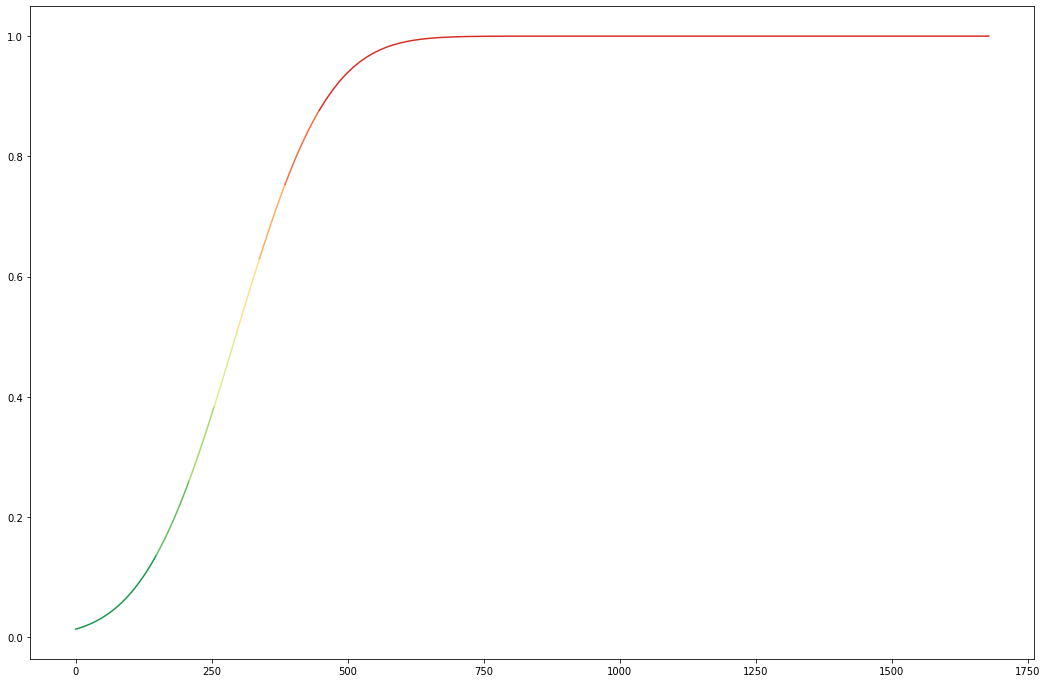

0.01355009899029599

In [16]:
for i, (lower_bound, upper_bound) in enumerate(zip(color_bounds, color_bounds[1:] + [maximum_travel_time])):
    time_X = np.linspace(lower_bound, upper_bound, 100)
    plt.plot(
        time_X, scipy.stats.norm.cdf(time_X, loc=time_mean, scale=time_variance),
        color=diverging_colors[i])
plt.show()
scipy.stats.norm.cdf(0, loc=time_mean, scale=time_variance)

# Visualize the travel times to the stops

So now as we have our bounds and colors let us try to visualize the travel times to the stops again.

In [17]:
def configure_colorbar(sc, bounds, max_value):
    colorbar = plt.colorbar(sc, ticks=bounds + [max_value])
    colorbar.ax.set_yticklabels(
        [f'<= {bound:.0f}' for bound in bounds] +
        [f'<= {maximum_travel_time:.0f}'])
    colorbar.set_label(label='minutes', size='x-large')

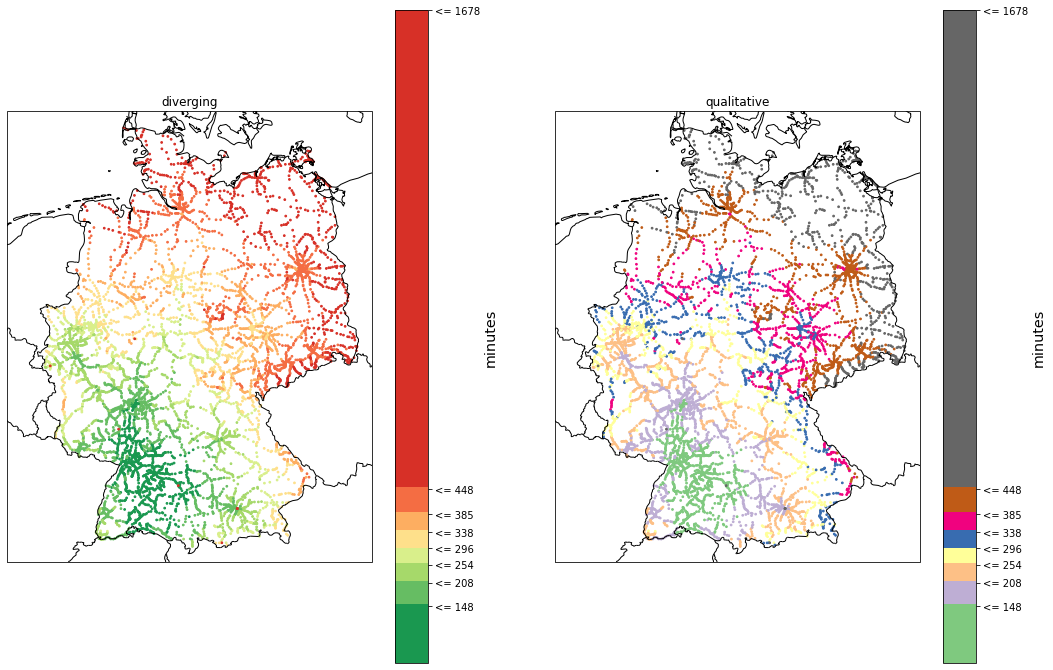

In [18]:
plt.figure()

for i, (title, colors) in enumerate((
    ('diverging', diverging_colors), ('qualitative', qualitative_colors))):
    ax = plt.subplot(1, 2, i + 1, projection=cartopy.crs.Mercator())
    ax.set_extent(germany_rectangle)
    ax.add_feature(cartopy.feature.BORDERS)
    ax.add_feature(cartopy.feature.COASTLINE)
    
    ax.set_title(title)

    cm = create_colormap_absolute(
        [(bound, color) for bound, color in zip(color_bounds, colors)] + [(maximum_travel_time, colors[-1])],
        maximum_travel_time,
        discret=True)
    sc = plt.scatter(
        longitude_x, latitude_y, c=minimum_travel_time_z,
        s=3,
        vmin=minimum_travel_time, vmax=maximum_travel_time,
        cmap=cm,
        transform=cartopy.crs.PlateCarree())
    configure_colorbar(sc, color_bounds, maximum_travel_time)

plt.show()

First of all we see that by using qualitative colors it is much easier to distinguish the different groups.  
So I guess choosing qualitative colors is better in this case.  

Now we need to ask us does this make sense?  
(Assuming we found a perfect estimator, so e.g. likelihood for travel times < 0 is not > 0 $\Rightarrow$ we do not need a offset (time_cdf_0) while determining the bounds of our colors:)  
Let our dataset be the minimum travel time to each stop.  
If we think about how we chose to color our data we see that we colored our data such that the likelihood of a random element of our dataset has the same likelihood to belong to one of those colors.  
So we see in this map groups of different time ranges for which we have the same likelihood that a random element of our dataset to belong to them.  
<!-- To say it in other words:  
Let e be an arbitary element of our dataset, g be a mapping from a color to a set which contains the stops with this color  
and let P be our likelihood function.  
Further let colors be the set of the colors of the different groups.  
Then it should hold P(e $\in$ g($c_i$)) = P(e $\in$ g($c_j$)) $\forall c_i \in colors \forall c_j \in colors$.  -->

I think it makes sense to create such a visualization as it shows you how the travel times are distributed.  
E.g. for red or dark gray (depending on which plot you look at)  
you see that you need a much larger time range in order to create a group with the same likelihood as the other groups.  
On the other side if you look at such a map are you not likely be interested in the places you can visit quickly?  
In this case I think it would make sense to choose other factors to determine which data a color should represent.  
E.g. I think that the time range of the the group with the smallest travel times is to large.  

# Looking for other ways to cluster the travel time

## travel time clustering via t-SNE

In the lecture "data literacy" t-SNE was introduced as method to reduce dimensionality of data and  
after working on the related exercise sheet/after using it you could get the impression that it is suitable for creating clusters.  
So I did a [research](https://stats.stackexchange.com/a/264647) and found out that people suggested against it.  

## travel time clustering via kmeans

Let us see how kmeans roughtly works by looking at a [description of a possible implementation](https://en.wikipedia.org/w/index.php?title=K-means_clustering&oldid=1067009361#Standard_algorithm_(naive_k-means)).  

1. First of all defined the initial centroids (points which could be in our data).  
   There are multiple ways to do that.  
   For example you could choose some values by random  
   or you could just use the first k elements of our dataset or something else.  
2. Now we assign each of our data points to the nearest centroid.  
   In other words assign each data point to the centroid with the least squared euclidean distance.  
3. For each centroid calculate the mean of the assigned data points and  
   use the result to replace the centroid.  
4. Repeat step two and three until the centroid do not change anymore.  

One of the disadvantages of kmean is that it depends on the initial value of the centroids.  
In our case we will use the dependency on the initial values to our advantage.  
As I already described above we are interested in the places  
we can visit quickly and we limit our self to use max. 8 colors.  
So we will *try to* choose the initial centroids as small  
as possible with a distance to each other such that we can separate the travel time into 8 cluster.  

Side note: We should not need to normalize our data as we only have *one* feature.

In [19]:
def search_cluster(data, clusters):
    maximum = max(data)
    
    for i in range(1, int(maximum // clusters)):
        initial_centroids = np.arange(clusters) * i
        codebook, distortion = scipy.cluster.vq.kmeans(data, initial_centroids)
        if codebook.shape[0] == clusters:
            return codebook, distortion
    raise ValueError(f"Can't find separation into {clusters} clusters")

In [20]:
centroids, centroids_mean_distance = search_cluster(minimum_travel_time_z, 8)
centroids, centroids_mean_distance

(array([ 52.99126638, 117.27692308, 163.53197279, 218.04217926,
        276.7034291 , 350.86528029, 436.27251553, 563.60540541]),
 19.47084301976001)

Now as we have our centroids we need to calculate the upper bound of these clusters.  

In [21]:
assert all(current_centroid < next_centroid
           for current_centroid, next_centroid in zip(centroids, centroids[1:]))
cluster_upper_bounds = [
    current_centroid + (next_centroid - current_centroid) / 2
    for current_centroid, next_centroid
    in zip(centroids, centroids[1:])]
cluster_upper_bounds

[85.13409472623447,
 140.40444793301936,
 190.78707602548928,
 247.3728041814412,
 313.78435469517524,
 393.5688979086406,
 499.9389604666778]

In [22]:
color_bounds = [0] + cluster_upper_bounds

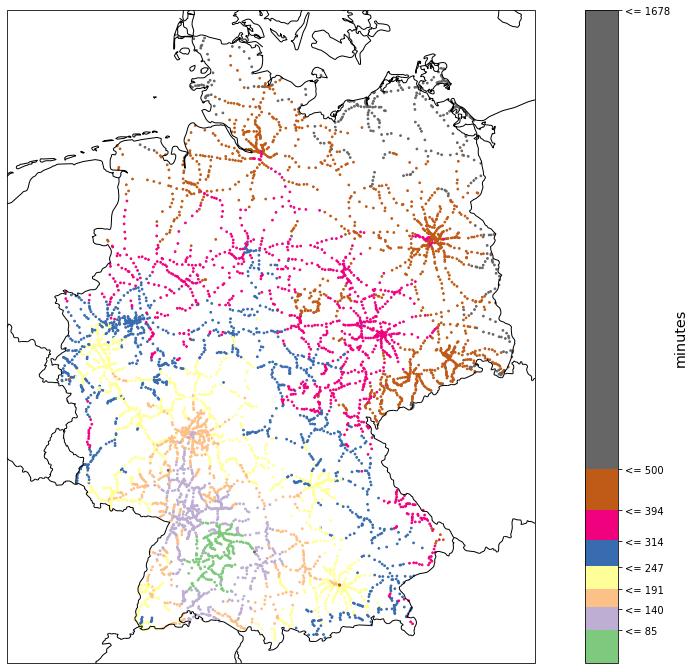

In [23]:
ax = plt.axes(projection=cartopy.crs.Mercator())
colors = qualitative_colors
ax.set_extent(germany_rectangle)
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.COASTLINE)

cm = create_colormap_absolute(
    [(bound, color) for bound, color in zip(color_bounds, colors)] + [(maximum_travel_time, colors[-1])],
    maximum_travel_time,
    discret=True)
sc = plt.scatter(
    longitude_x, latitude_y, c=minimum_travel_time_z,
    s=3,
    vmin=minimum_travel_time, vmax=maximum_travel_time,
    cmap=cm,
    transform=cartopy.crs.PlateCarree())
configure_colorbar(sc, color_bounds, maximum_travel_time)

plt.show()